# Looking for ortholog ID families with conserved compactness across lenght variations

In [1]:
# Imports
from Bio import SeqIO
import json
import os
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr, spearmanr
from scipy.stats import f as f_dist
from scipy.optimize import curve_fit
import requests

sys.path.append('../../src')
import data_utils
import analyse_utils
import mdtraj as md

plt.rcParams["font.family"] = "Liberation Sans"
plt.rcParams["font.weight"] = "normal"

## Data preparation

In [154]:
# Querying API
orthodb_e1a_group = '19343at10239' 
url = f"https://data.orthodb.org/current/orthologs?id={orthodb_e1a_group}"
data = requests.get(url).json()

In [165]:
# Parsing response
# Extracting UniProt IDs
uids = []
uids_species = []
no_uids_ids = []
no_uids_species = []
for id in range(len(data['data'])):

    # Skipping species without UniProt entries
    try:
        for protein in data['data'][id]['genes']:
            uids.append(protein['uniprot']['id'])
            uids_species.append(data['data'][id]['organism']['name'])
    except KeyError:
        no_uids_ids.append(data['data'][id]['genes'][0]['gene_id']['param'])
        no_uids_species.append(data['data'][id]['organism']['name']) 

# Handling proteins with no UniProt IDs
if no_uids_species:
    print(f"The following {len(no_uids_species)}/{len(data['data'])} entries had no UniProt IDs")
    print(*[f" - {specie}" for specie in no_uids_species], sep="\n")

# Defining UniProt IDs
orthologs = pd.DataFrame({'uniprot_id': uids,
                          'name': None,
                          'description': None,
                          'species': None,
                          'sequence': None})

The following 5/28 entries had no UniProt IDs
 - Human mastadenovirus A
 - Human mastadenovirus B
 - Human mastadenovirus D
 - Human mastadenovirus F
 - Tree shrew adenovirus 1


In [166]:
# Collecting metadata
deleted_records = []
for id, row in orthologs.iterrows():
    try:
        name, desc, spec, seq = data_utils.get_protein_metadata(row.uniprot_id)
    except:
        deleted_records.append(id)
        continue
    orthologs.loc[id] = {
            'uniprot_id': row.uniprot_id,
            'name': name,
            'description': desc,
            'species': spec,
            'sequence': seq}
    
# Discarding deleted UniProt records
if deleted_records:
    print(f"The following {len(deleted_records)}/{len(orthologs)} UniProt IDs returned no records:")
    for id in deleted_records:
        print(f" - {orthologs.loc[id].uniprot_id}")
    orthologs.drop(index=deleted_records, inplace=True)

# Extracting host
orthologs['host'] = orthologs.species.apply(lambda species: species.split(' ')[0])

The following 1/23 UniProt IDs returned no records:
 - Q695T6


In [167]:
# Getting IDR linkers
not_linker = []
linker_seqs = []
linker_locs = []
for id, row in orthologs.iterrows():
    try:
        seq, loc, reg = data_utils.get_protein_idr(uniprot_id=row.uniprot_id, i_idr=0, length_order=True)
        if reg != 'INT':
            not_linker.append((id, row.uniprot_id))
        else:
            linker_seqs.append(seq)
            linker_locs.append(loc)
    except ValueError:
        not_linker.append((id, row.uniprot_id))
if not_linker:
    print(f"The following {len(not_linker)}/{len(orthologs)} UniProt IDs did not return intrinsically disordered linker regions:")
    for id, uid in not_linker:
        print(f" - {uid}")
        orthologs.drop(index=id, inplace=True)
orthologs['linker_sequence'] = linker_seqs
orthologs['linker_location'] = linker_locs

The following 9/22 UniProt IDs did not return intrinsically disordered linker regions:
 - A0A1B0UHZ2
 - A0A1X9RIQ2
 - A0A1X9RIS6
 - Q64842
 - A0A059XN88
 - Q5UW25
 - Q5C8R3
 - A0A0M4MQM5
 - A0A1L3INV8


In [173]:
# Displaying final linkers
orthologs

,uniprot_id,name,description,species,sequence,host,linker_sequence,linker_location
5,G9G840,G9G840_9ADEN,Early E1A protein,Chimpanzee adenovirus Y25,MRHLRDLPDEKIIIASGNEILELVVNAMMGDDPPEPPTPFEAPSLH...,Chimpanzee,ALLAAEEASSPSSDSDSSLHTPRPGRGEKKIPELK,72:107
6,B9A5L3,B9A5L3_9ADEN,Early E1A protein,Human adenovirus 54,MRHLHLLSSTVPIDMAALLLEDYVNTILEDELHLSPFELGPTLQDL...,Human,EDESSPLEEDHPSPPDLTNDTPLQVRKPTPVRPSGERR,187:225
8,J9Z5B4,J9Z5B4_9ADEN,Early E1A protein,Human mastadenovirus C,MRHIICHGGVITEEMAASLLDQLIEEVLADNLPPPSHFEPPTLHEL...,Human,VSEPEPEPEPEPEPARPTRRPKLVPAILRRPTSPVSRECNSSTDSC...,186:245
9,Q6H1D8,Q6H1D8_9ADEN,Early E1A protein,Human mastadenovirus E,MRHLRDLPDEEIIIASGSEILELVVNAMMGDDHPEPPTPFETPSLH...,Human,VSDADDETPTTESTLSPPEIGTSPSDNIVRP,190:221
11,A0A0M4NFL9,A0A0M4NFL9_9ADEN,Early E1A protein,Simian adenovirus 13,MRTPLVEGDIPVRFAAELLAALAEEVFADVEPPRAFEDVSLHDLFD...,Simian,EAEVDEPDTTTDDQGRAQSPPKLTQDAPVNVIRPRPIRPSSRRRNAVDS,201:250
12,A0A0M4MEX3,A0A0M4MEX3_9ADEN,Early E1A protein,Simian adenovirus 16,MRHLALEMISELLDLGLDTIDGWLHTEFAPVPAGVSHNMSLHEMYD...,Simian,VSDSEPDEPDSTTADSNHGSPPTLRCTPPRDLPRPVPVKASPGKRP...,192:244
13,H8PFZ0,H8PFZ0_9ADEN,Early E1A protein,Simian adenovirus 18,MRMLPEIFTGSWEDVFQGLLESEDNFPQPPEPEELPEVSLHDLFDV...,Simian,DAEGDSESPAGPSQPSPCSLTATP,182:206
15,F6KST5,F6KST5_9ADEN,Early E1A protein,Simian adenovirus 20,MRNFILSPGLPPTVAAELLEDIVSGALGDDPQVISHFCDDFSLHDL...,Simian,EEPDSTTGSVDDKPSPPQMTEKPERPRPNILKPKPQRVSSRRR,197:240
17,F2WTJ6,F2WTJ6_9ADEN,Early E1A protein,Simian adenovirus 49,MKTWGLDCGLYPQEVDEWLRTEYCPTPGYYGENLSLHDLYDIDVDA...,Simian,DAEGEPDSTTGHSGGPGSPPKLHNTPPRNVPRPVPLR,195:232
18,A0A0M5L3X1,A0A0M5L3X1_9ADEN,Early E1A protein,Simian adenovirus 8,MKTWGLDCGLNLLEVDEWLRTEFCPTPGYYGENLSLHDLYDLDVDG...,Simian,DADGEPDSTTGNSGGPGSPPKLHNTPPKNVPRPVPV,195:231


## Analysis

### E1A - Sanity checking

#### Preparing SVR model and features

In [3]:
import itertools
from localcider.sequenceParameters import SequenceParameters
from residues import residues

# Loading SVR model
import joblib
model = joblib.load('svr_model.joblib')

def svr_features(seq,Nc=0,Cc=0,Hc=0.5,residues=residues.set_index('one')):
    """df: DataFrame to be populated with sequence properties
    r: DataFrame of aa-specific parameters"""
    seq = list(seq).copy()   
    fasta_kappa = np.array(seq.copy())
    N = len(seq)
    r = residues.copy()
    
    # calculate properties that do not depend on charges
    mean_lambda = np.mean(r.loc[seq].AH_lambda)

    pairs = np.array(list(itertools.combinations(seq,2)))
    pairs_indices = np.array(list(itertools.combinations(range(N),2)))
    # calculate sequence separations
    ij_dist = np.diff(pairs_indices,axis=1).flatten().astype(float)
    # calculate lambda sums
    ll = r.AH_lambda.loc[pairs[:,0]].values+r.AH_lambda.loc[pairs[:,1]].values
    # calculate SHD
    beta = -1
    shd = np.sum(ll*np.power(np.abs(ij_dist),beta))/N
    SeqOb = SequenceParameters(''.join(seq))
    
    # fix charges
    if Nc == 1:
        r.loc['X'] = r.loc[seq[0]]
        r.loc['X','q'] = r.loc[seq[0],'q'] + 1.
        seq[0] = 'X'
        if r.loc['X','q'] > 0:
            fasta_kappa[0] = 'K'
        else:
            fasta_kappa[0] = 'A'
    if Cc == 1:
        r.loc['Z'] = r.loc[seq[-1]]
        r.loc['Z','q'] = r.loc[seq[-1],'q'] - 1.
        seq[-1] = 'Z'
        if r.loc['Z','q'] < 0:
            fasta_kappa[-1] = 'D'
        else:
            fasta_kappa[-1] = 'A'
    if Hc < 0.5:
        r.loc['H', 'q'] = 0
        fasta_kappa[np.where(np.array(seq) == 'H')[0]] = 'A'
    elif Hc >= 0.5:
        r.loc['H', 'q'] = 1
        fasta_kappa[np.where(np.array(seq) == 'H')[0]] = 'K'
            
    # calculate properties that depend on charges
    pairs = np.array(list(itertools.combinations(seq,2)))
    # calculate charge products
    qq = r.q.loc[pairs[:,0]].values*r.q.loc[pairs[:,1]].values
    # calculate SCD
    scd = np.sum(qq*np.sqrt(ij_dist))/N
    SeqOb = SequenceParameters(''.join(fasta_kappa))
    kappa = SeqOb.get_kappa()
    fcr = r.q.loc[seq].abs().mean()

    return np.array([scd, shd, kappa, fcr, mean_lambda])

def predict_nu(seq):
    features = svr_features(seq).reshape(1, -1)
    nu = float(model.predict(features))
    return nu

/storage1/fknudsen/software/miniconda3/envs/orthoidp/lib/python3.10/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator SVR from version 1.0.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


#### From Gonzáles-Foutel paper

In [4]:
# Loading metadata
gonzales = analyse_utils.load_metadata('../e1a_linkers/e1a_linkers.json', join=False)[0]
gonzales

,sequence,host
CA_CAdV1_linker,ELENSRSPSPLLCDWCAEADSESTISTETDVGFTLNTPPVSPLPSY...,CA
HA_HAdV31_linker,DVESAGEDSNEQAVNDFFPESFILAAAEGVILPEPPVLSPICEPIG...,HA
HC_SAdV34_linker,DVVGPSDPNEQAVSSFFPESMLLASQEGVELETPPPIVDSPDPPQL...,SA
HE_SAdV22_linker,EVDVPENDPNEEAVNDLFSDAALLAAEQANTDSGSDSDSSLHTPRP...,SA
HG_HAdV52_linker,EVDPPQDPNEDAVNSMFPECLFEAAEEGSHSSEESKRGEEL,HA
SA_SAdV20_linker,DPGTETETDPLATAVDEFFPESMLLEADMPPHLESPVQPGAGGAMP...,SA
BA_BAdV1_linker,DDASDVVSLFFPELEVQQDLPTAEEVED,BA
CA_CAdV2_linker,ELETSHSPFVGLCDSCAEADTDSSASTEADSGFSPLSTPPVSPIPP...,CA
HB_HAdV11_linker,EVEGSEDSNEEAVNGFFTDSMLLAANEGLELDPPLDTFDTPGVIVE...,HA
HC_SAdV43_linker,DVLVDVNDPNEEAVSTFFPESALLAAQEGFDLHTPPLPILESPLPE...,SA


In [5]:
# Loading trajectories
gonzales['traj'] = gonzales.apply(lambda row: md.load_dcd(*['/'.join(['../e1a_linkers/results', row.name, filename]) for filename  in ['traj.dcd', 'top.pdb']]), axis=1)

In [6]:
# Computing sequence lengths
gonzales['length'] = gonzales.apply(lambda row: len(row.sequence), axis=1)
gonzales.sort_values('length', inplace=True)

In [7]:
# Computing scaling exponent
gonzales['nu_'] = gonzales.apply(lambda row: analyse_utils.compute_scaling_exponent(row.traj)[0], axis=1)
gonzales['nu'] = gonzales.apply(lambda row: analyse_utils.compute_scaling_exponent(row.traj, r0_fix=None)[0], axis=1)
gonzales['R0'] = gonzales.apply(lambda row: analyse_utils.compute_scaling_exponent(row.traj, r0_fix=None)[1], axis=1)

In [8]:
# Predicting scaling exponent
gonzales['nu_svr'] = gonzales.apply(lambda row: predict_nu(row.sequence), axis=1)

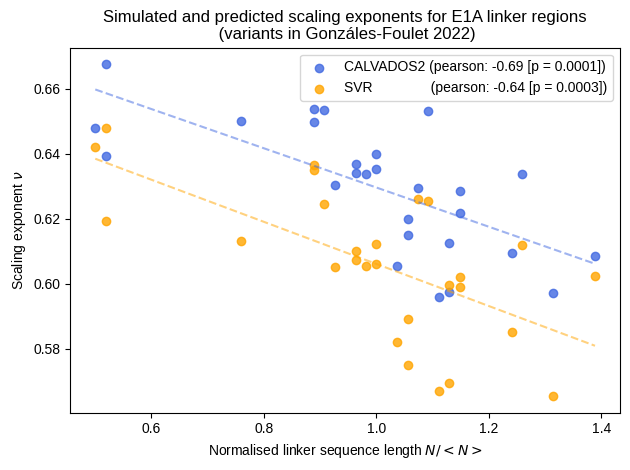

In [20]:
# Correlation
corr_calvados, p_corr_calvados = pearsonr(gonzales.length, gonzales.nu)
corr_svr, p_corr_svr = pearsonr(gonzales.length, gonzales.nu_svr)

# Plotting
plt.scatter(gonzales.length/gonzales.length.mean(), gonzales.nu,     label=f'CALVADOS2 (pearson: {corr_calvados:.2f} [p = {p_corr_calvados:.4f}])', c='royalblue', alpha=0.8)
plt.scatter(gonzales.length/gonzales.length.mean(), gonzales.nu_svr, label=f'SVR               (pearson: {corr_svr:.2f} [p = {p_corr_svr:.4f}])',       c='orange', alpha=0.8)

N = np.array([gonzales.length.min()/gonzales.length.mean(), gonzales.length.max()/gonzales.length.mean()])
slope_calvados, intersect_calvados = np.polyfit(gonzales.length/gonzales.length.mean(), gonzales.nu, 1)
plt.plot(N, N*slope_calvados+intersect_calvados, c='royalblue', alpha=0.5, linestyle='--')
slope_svr, intersect_svr = np.polyfit(gonzales.length/gonzales.length.mean(), gonzales.nu_svr, 1)
plt.plot(N, N*slope_svr+intersect_svr, c='orange', alpha=0.5, linestyle='--')

plt.legend()
plt.xlabel("Normalised linker sequence length $N/<N>$")
plt.ylabel("Scaling exponent $\\nu$")
plt.title("Simulated and predicted scaling exponents for E1A linker regions\n (variants in Gonzáles-Foulet 2022)")

plt.tight_layout()

In [25]:
translate

0.023531360259478655

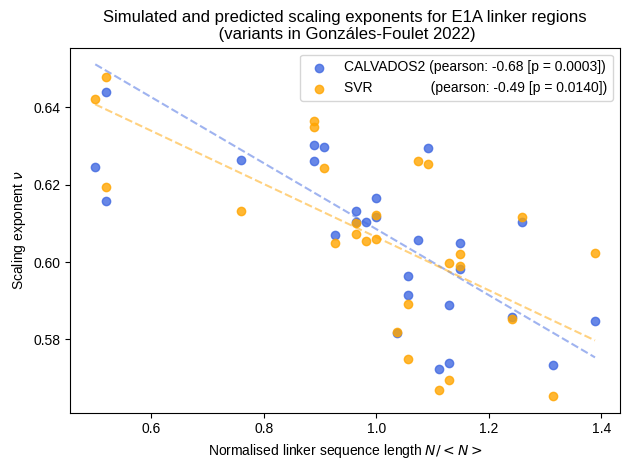

In [24]:
# Plotting with vertical translation
translate = (gonzales.nu - gonzales.nu_svr).mean()

plt.scatter(gonzales.length/gonzales.length.mean(), gonzales.nu-translate,     label=f'CALVADOS2 (pearson: {corr_calvados:.2f} [p = {p_corr_calvados:.4f}])', c='royalblue', alpha=0.8)
plt.scatter(gonzales.length/gonzales.length.mean(), gonzales.nu_svr, label=f'SVR               (pearson: {corr_svr:.2f} [p = {p_corr_svr:.4f}])',       c='orange', alpha=0.8)

plt.plot(N, N*slope_calvados+intersect_calvados-translate, c='royalblue', alpha=0.5, linestyle='--')
plt.plot(N, N*slope_svr+intersect_svr, c='orange', alpha=0.5, linestyle='--')

plt.legend()
plt.xlabel("Normalised linker sequence length $N/<N>$")
plt.ylabel("Scaling exponent $\\nu$")
plt.title("Simulated and predicted scaling exponents for E1A linker regions\n (variants in Gonzáles-Foulet 2022)")

plt.tight_layout()

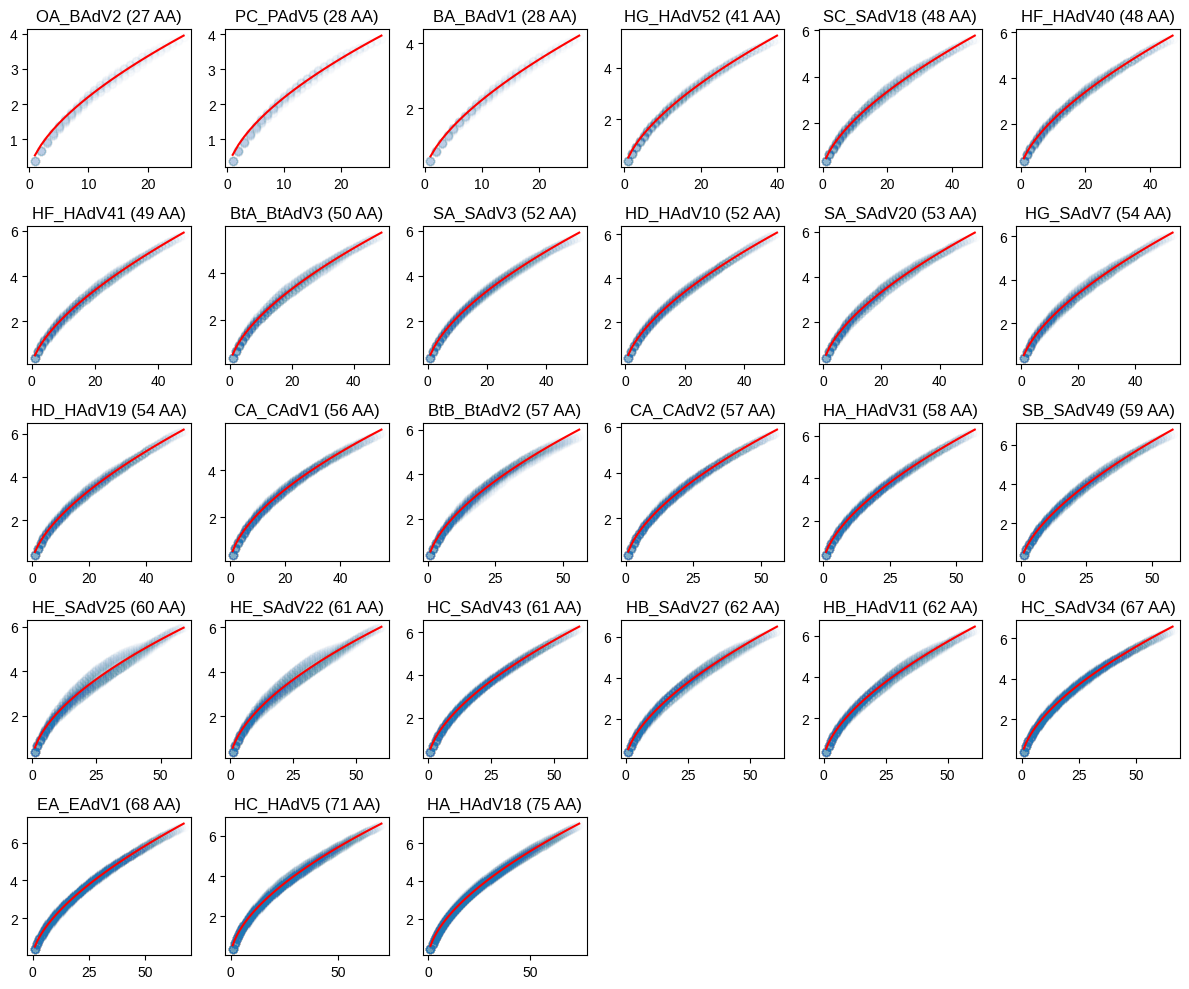

In [42]:
# Plotting scaling law fits
plt.figure(figsize=(2*6, 2*5))
for i, idx in enumerate(gonzales.index):
    plt.subplot(5,6,i+1)
    analyse_utils.compute_scaling_exponent(gonzales.loc[idx, 'traj'], r0_fix=None, plot=True)
    plt.title(f"{idx[:-7]} ({gonzales.loc[idx, 'length']} AA)")
plt.tight_layout()

#### From OrthoDB

In [176]:
# Setting OrthoDB variants
orthodb = orthologs[['linker_sequence']]
orthodb.columns= ['sequence']
orthodb.index = orthologs['name']

In [ ]:
# Computing sequence lengths
orthodb['length'] = orthodb.apply(lambda row: len(row.sequence), axis=1)
orthodb.sort_values('length', inplace=True)

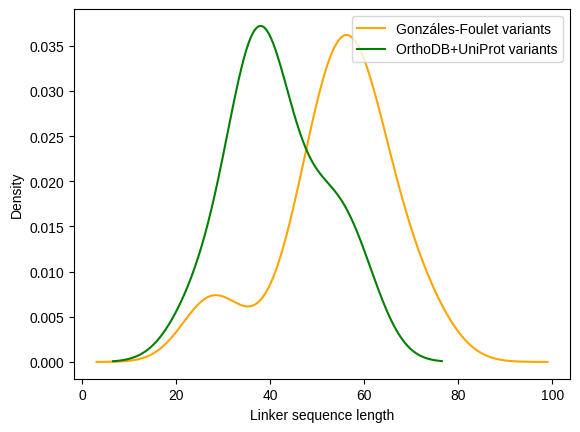

In [205]:
# Checking length distributions
gonzales.length.plot.density(color='orange', label='Gonzáles-Foulet variants')
orthodb.length.plot.density(color='green', label='OrthoDB+UniProt variants')
plt.xlabel("Linker sequence length")
plt.legend(loc='upper right')

In [ ]:
# Predicting scaling exponent
orthodb['nu_svr'] = orthodb.apply(lambda row: predict_nu(row.sequence), axis=1)

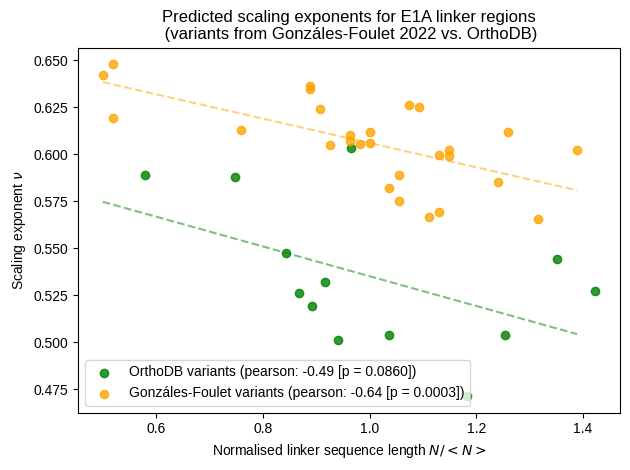

In [181]:
# Correlation
corr_orthodb, p_corr_orthodb = pearsonr(orthodb.length, orthodb.nu_svr)
corr_gonzales, p_corr_gonzales = pearsonr(gonzales.length, gonzales.nu_svr)


# Plotting
plt.scatter(orthodb.length/orthodb.length.mean(), orthodb.nu_svr,     label=f'OrthoDB variants (pearson: {corr_orthodb:.2f} [p = {p_corr_orthodb:.4f}])', c='green', alpha=0.8)
plt.scatter(gonzales.length/gonzales.length.mean(), gonzales.nu_svr, label=f'Gonzáles-Foulet variants (pearson: {corr_gonzales:.2f} [p = {p_corr_gonzales:.4f}])',  c='orange', alpha=0.8)

N = np.array([gonzales.length.min()/gonzales.length.mean(), gonzales.length.max()/gonzales.length.mean()])
slope_orthodb, intersect_orthodb = np.polyfit(orthodb.length/orthodb.length.mean(), orthodb.nu_svr, 1)
plt.plot(N, N*slope_orthodb+intersect_orthodb, c='green', alpha=0.5, linestyle='--')
slope_gonzales, intersect_gonzales = np.polyfit(gonzales.length/gonzales.length.mean(), gonzales.nu_svr, 1)
plt.plot(N, N*slope_gonzales+intersect_gonzales, c='orange', alpha=0.5, linestyle='--')

plt.legend()
plt.xlabel("Normalised linker sequence length $N/<N>$")
plt.ylabel("Scaling exponent $\\nu$")
plt.title("Predicted scaling exponents for E1A linker regions\n (variants from Gonzáles-Foulet 2022 vs. OrthoDB)")

plt.tight_layout()

### Orthologs

In [2]:
# Loading data
dfs = []
for filename in os.listdir('data'):
    dfs.append(pd.read_csv('data/'+filename))
data = pd.concat(dfs).dropna()
data

,protein,fasta,N,HUMAN,first,last,mean_lambda,faro,fR,fK,...,fD,shd,N_FL,omaid,canonicalid,scd,kappa,fcr,ncpr,nu
0,HUMAN28529_96to137,ILNQPSTQIVANAKGAVTGAKDAVTTTVTGAKDSVASTITGV,42,HUMAN28529_96to137,96,137,0.362880,0.000000,0.000000,0.071429,...,0.047619,2.376418,693.0,HUMAN28529,AGRG1_HUMAN,-0.054573,0.151679,0.119048,0.023810,0.582
1,NOMLE04692_141to182,ILNQPSTQIVASAKGAVTGAKDAVTTTVTGAKDSVASTITGV,42,HUMAN28529_96to137,141,182,0.363760,0.000000,0.000000,0.071429,...,0.047619,2.382591,206.0,NOMLE04692,G1S354,-0.054573,0.151679,0.119048,0.023810,0.582
2,PROCO08232_96to137,ILNQPSTQVVANAKGVVTGAKDAVTTTVTGAKDSVASTITGV,42,HUMAN28529_96to137,96,137,0.353358,0.000000,0.000000,0.071429,...,0.047619,2.311028,434.0,PROCO08232,A0A2K6GS49,-0.054573,0.151679,0.119048,0.023810,0.583
3,SAIBB13662_96to137,ILNQPSTQVVANAKDAVTGAKDAMTTTVTGAKDSVASTITGV,42,HUMAN28529_96to137,96,137,0.346790,0.000000,0.000000,0.071429,...,0.071429,2.264823,437.0,SAIBB13662,A0A2K6UAA3,-0.070864,0.073626,0.142857,0.000000,0.586
4,MYOLU08979_96to137,ILNQPTKQVVANAKGAVTGAKDAVTTTVTGAKDSVTSTITGV,42,HUMAN28529_96to137,96,137,0.350487,0.000000,0.000000,0.095238,...,0.047619,2.293295,451.0,MYOLU08979,G1PH01,0.002937,0.154946,0.142857,0.047619,0.583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33806,CAVAP12566_485to535,PSFLLLIQQDMTQPKRTFTTVRTPKDIASENSISRCVTNSFPLLLQ...,50,HUMAN15348_487to547,485,535,0.452931,0.060000,0.060000,0.040000,...,0.040000,3.138611,554.0,CAVAP12566,ENSCAPG00000008308.1,-0.087124,0.309776,0.160000,0.040000,0.547
33807,TAKRU02187_454to497,GATDGAQKDSTVKKVHQVTGETRSSSVVAFSPDSCLTCPTSPAV,44,HUMAN15348_487to547,454,497,0.370222,0.022727,0.022727,0.068182,...,0.068182,2.495675,261.0,TAKRU02187,H2S765,-0.220314,0.218576,0.181818,0.000000,0.570
33808,LINUN04385_463to536,AYMGSTESLDSLGGAFALNGTWYGIELDRPAGKNDGSVNGDRYFTC...,74,HUMAN15348_487to547,463,536,0.469801,0.108108,0.040541,0.054054,...,0.067568,3.661558,571.0,LINUN04385,g29387,-0.510270,0.222715,0.202703,-0.013514,0.520
33809,CAPTE31298_494to626,DMDESLEPLKMQPLEPSRRLSNGSNGSQLSPNSSFSKKTSRPWSSG...,133,HUMAN15348_487to547,494,626,0.478558,0.060150,0.082707,0.060150,...,0.022556,4.308551,634.0,CAPTE31298,N1PBE5,-0.009880,0.230914,0.233083,0.052632,0.500


#### First iteration of work

In [4]:
# Grouping by ortholog families
families = pd.DataFrame(index=data.HUMAN.unique())
families['nu'] = data.groupby('HUMAN').nu.apply(np.array)
families['N'] = data.groupby('HUMAN').N.apply(np.array)
families['kappa'] = data.groupby('HUMAN').kappa.apply(np.array)
_data = data.set_index('protein').loc[families.index]
families.index = _data.canonicalid + ' [' + _data['first'].astype(str) + ':' + _data['last'].astype(str) + ']'

In [5]:
# Filtering data points by z-score of linker length
from scipy.stats import zscore
z_cutoff = 1.5
families.nu = families.apply(lambda row: row.nu[zscore(row.N) < z_cutoff], axis=1)
families.N = families.apply(lambda row: row.N[zscore(row.N) < z_cutoff], axis=1)
families = families[families.N.apply(len) > 1]

In [5]:
# Filtering family by number of unique linker lengths
unique_entry_cutoff = 5
families = families[families.N.apply(lambda N: len(np.unique(N))) > unique_entry_cutoff]

In [6]:
# Filtering families by length range
range_cutoff = 10
families = families[families.N.apply(lambda N: N.max() - N.min()) > range_cutoff]

In [7]:
# Counting number of filtered families
print(f"Filtered families: {len(data.HUMAN.unique()) - len(families)}/{len(data.HUMAN.unique())}")

Filtered families: 2730/15140


In [8]:
# Calculating correlations for all families
def pearson_corr_row(row):
    corr, p = pearsonr(row.N, row.nu)
    row['pcorr'] = corr
    row['pcorr_p'] = p
    return row
def spearman_corr_row(row):
    row['N_lognormalised'] = np.log(row.N/row.N.mean())
    corr, p = spearmanr(row.N_lognormalised, row.nu)
    row['scorr'] = corr
    row['scorr_p'] = p
    return row

families = families.apply(pearson_corr_row, axis=1)
families = families.apply(spearman_corr_row, axis=1)

/storage1/fknudsen/software/miniconda3/envs/orthoidp/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/storage1/fknudsen/software/miniconda3/envs/orthoidp/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/storage1/fknudsen/software/miniconda3/envs/orthoidp/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/storage1/fknudsen/software/miniconda3/envs/orthoidp/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Con

(0.0, 150.0)

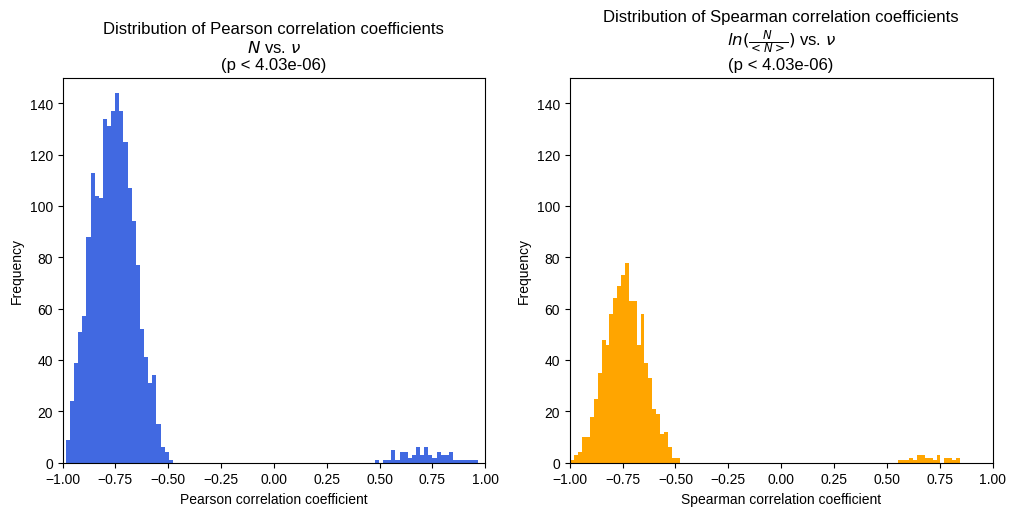

In [9]:
# plotting distribution of correlation coefficients
p_cutoff = 0.05/len(families)

plt.figure(figsize=(12,5))
plt.subplot(121)
families[families.pcorr_p < p_cutoff].pcorr.plot.hist(bins=100, color='royalblue')
plt.xlabel('Pearson correlation coefficient')
plt.title('Distribution of Pearson correlation coefficients'+'\n$N$ vs. $\\nu$'+f'\n(p < {p_cutoff:.2e})')
plt.xlim(-1,1)
plt.ylim(0,150)

plt.subplot(122)
families[families.scorr_p < p_cutoff].scorr.plot.hist(bins=100, color='orange')
plt.xlabel('Spearman correlation coefficient')
plt.title('Distribution of Spearman correlation coefficients'+'\n$ln(\\frac{N}{<N>})$ vs. $\\nu$'+f'\n(p < {p_cutoff:.2e})')
plt.xlim(-1,1)
plt.ylim(0,150)

Text(0.5, 1.0, 'Volcano plot of Spearman correlation coefficients\n$ln(\\frac{N}{<N>})$ vs. $\\nu$')

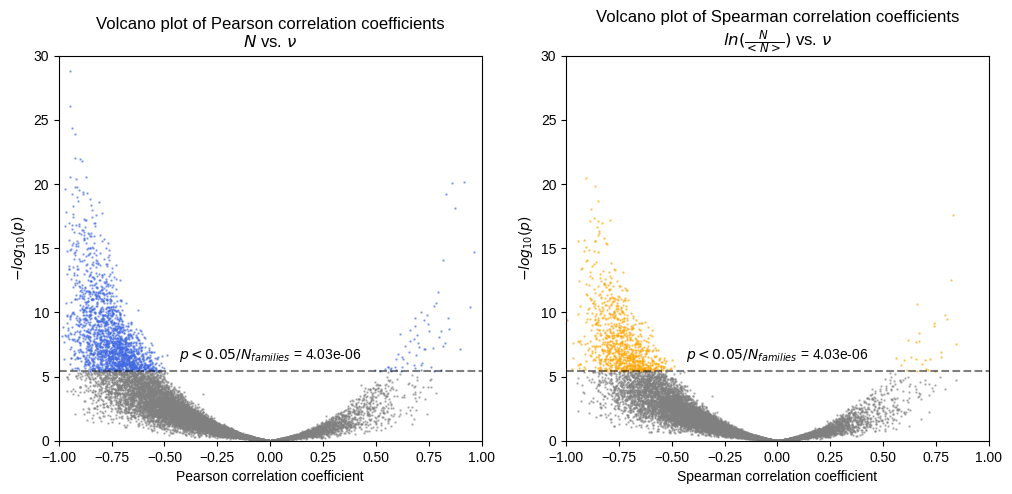

In [11]:
# Volcano plot
p_cutoff = 0.05/len(families)

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.scatter(families[families.pcorr_p < p_cutoff].pcorr, -np.log10(families[families.pcorr_p < p_cutoff].pcorr_p), alpha=0.5, s=0.6, color='royalblue')
plt.scatter(families[families.pcorr_p >= p_cutoff].pcorr, -np.log10(families[families.pcorr_p >= p_cutoff].pcorr_p), alpha=0.5, s=0.6, color='grey')
plt.hlines(-np.log10(p_cutoff), -1, 1, alpha=0.5, color='k', linestyles='--')
plt.text(0, -np.log10(p_cutoff)+1, '$p < 0.05 / N_{families}$'+f' = {p_cutoff:.2e}', horizontalalignment='center')
plt.xlim(-1,1)
plt.ylim(0,30)
plt.xlabel("Pearson correlation coefficient")
plt.ylabel("$-log_{10}(p)$")
plt.title("Volcano plot of Pearson correlation coefficients"+'\n$N$ vs. $\\nu$')

plt.subplot(122)
plt.scatter(families[families.scorr_p < p_cutoff].scorr, -np.log10(families[families.scorr_p < p_cutoff].scorr_p), alpha=0.5, s=0.6, color='orange')
plt.scatter(families[families.scorr_p >= p_cutoff].scorr, -np.log10(families[families.scorr_p >= p_cutoff].scorr_p), alpha=0.5, s=0.6, color='grey')
plt.hlines(-np.log10(p_cutoff), -1, 1, alpha=0.5, color='k', linestyles='--')
plt.text(0, -np.log10(p_cutoff)+1, '$p < 0.05 / N_{families}$'+f' = {p_cutoff:.2e}', horizontalalignment='center')
plt.xlim(-1,1)
plt.ylim(0,30)
plt.xlabel("Spearman correlation coefficient")
plt.ylabel("$-log_{10}(p)$")
plt.title("Volcano plot of Spearman correlation coefficients"+'\n$ln(\\frac{N}{<N>})$ vs. $\\nu$')

In [12]:
# Checking results
hits = families[(families.scorr_p < p_cutoff) & (families.scorr < 0)].sort_values('scorr_p')
hits.iloc[:,[3,4,6,7]]

,pcorr,pcorr_p,scorr,scorr_p
CLPB_HUMAN [927:1047],-0.835438,2.159452e-15,-0.903788,3.510495e-21
E7ENX6 [72:390],-0.827594,1.906989e-17,-0.865292,1.464075e-20
ENSG00000125124.13 [1:101],-0.783797,7.203682e-15,-0.849184,2.085986e-19
E9PJG8 [1:130],-0.861084,6.753330e-17,-0.883887,8.542239e-19
A0A0D2X7Z3 [1:94],-0.849813,1.210575e-16,-0.868719,4.125585e-18
...,...,...,...,...
HMGA2_HUMAN [1:55],-0.806248,4.381457e-08,-0.725390,3.897753e-06
ATM_HUMAN [3357:3399],-0.361048,1.881893e-02,-0.645530,3.912972e-06
DAAF4_HUMAN [1:46],-0.445419,4.489233e-03,-0.664566,3.953907e-06
RAG1_HUMAN [123:223],-0.768111,1.182331e-10,-0.605766,3.988948e-06


In [12]:
# Confusion matrix of Pearson vs. Spearman direction and signficance
pd.crosstab(
    [np.where(families.scorr > 0, '+', '-'),
     families.scorr_p < p_cutoff],
    [np.where(families.pcorr > 0, '+', '-'),
     families.pcorr_p < p_cutoff],
    rownames=['Spearman', 'Significant'],
    colnames=['Pearson', 'Significant'])

Pearson                  +           -      
Significant          False True  False True 
Spearman Significant                        
+        False        1624    43   860    17
         True           10    17     0     0
-        False         560     2  7227  1133
         True            0     0   209   708

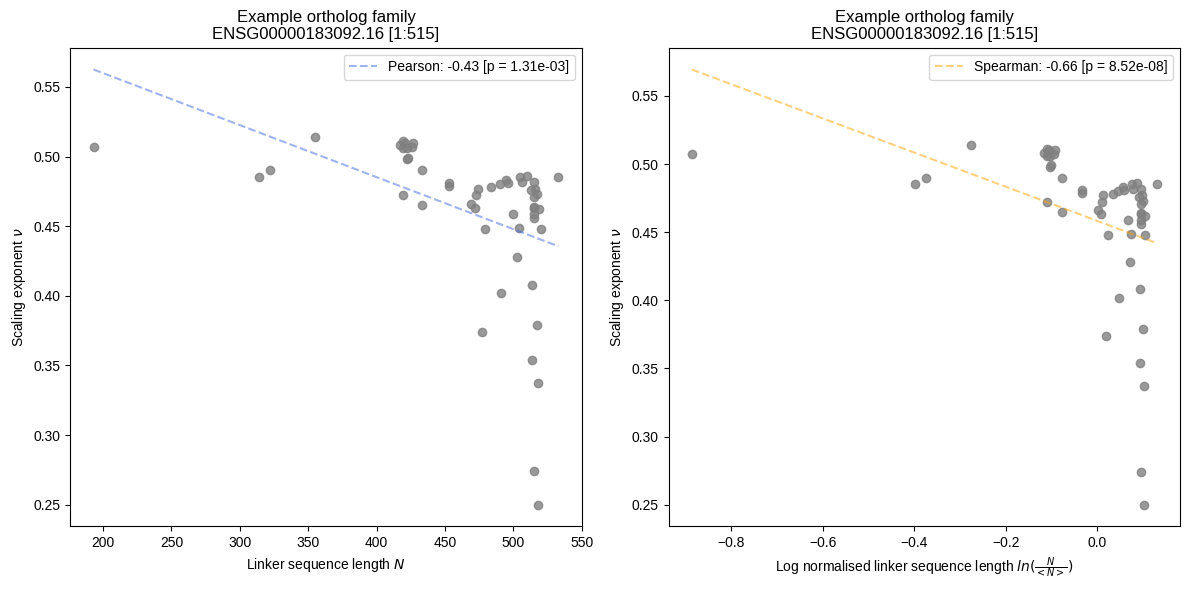

In [24]:
# Checking random significant ortholog family correlation
example = hits.sample(1).iloc[0]

# Plotting correlations
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.scatter(example.N, example.nu, c='gray', alpha=0.8)
N = np.array([example.N.min(), example.N.max()])
slope, intersect = np.polyfit(example.N, example.nu, 1)
plt.plot(N, N*slope+intersect, c='royalblue', alpha=0.5, linestyle='--', label=f'Pearson: {example.pcorr:.2f} [p = {example.pcorr_p:.2e}]')
plt.legend()
plt.xlabel("Linker sequence length $N$")
plt.ylabel("Scaling exponent $\\nu$")
plt.title(f"Example ortholog family\n{example.name}")

plt.subplot(122)
plt.scatter(np.log(example.N/example.N.mean()), example.nu, c='gray', alpha=0.8)
N = np.log(np.array([example.N.min(), example.N.max()]) / example.N.mean())
slope, intersect = np.polyfit(np.log(example.N/example.N.mean()), example.nu, 1)
plt.plot(N, N*slope+intersect, c='orange', alpha=0.5, linestyle='--', label=f'Spearman: {example.scorr:.2f} [p = {example.scorr_p:.2e}]')
plt.legend()
plt.xlabel("Log normalised linker sequence length $ln(\\frac{N}{<N>})$")
plt.ylabel("Scaling exponent $\\nu$")
plt.title(f"Example ortholog family\n{example.name}")


plt.tight_layout()

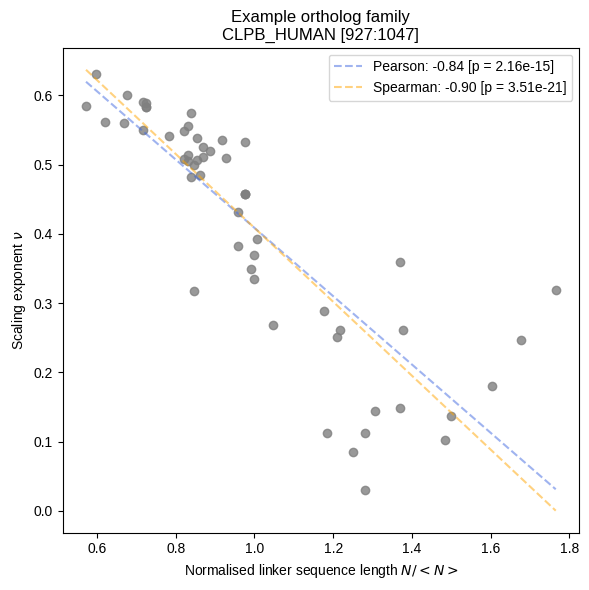

In [339]:
# Checking specific ortholog family correlation
example = families.loc['CLPB_HUMAN [927:1047]']

# Plotting correlation
plt.figure(figsize=(6, 6))
plt.scatter(example.N/example.N.mean(), example.nu, c='gray', alpha=0.8)
N = np.array([example.N.min(), example.N.max()]) / example.N.mean()
slope, intersect = np.polyfit(example.N/example.N.mean(), example.nu, 1)
plt.plot(N, N*slope+intersect, c='royalblue', alpha=0.5, linestyle='--', label=f'Pearson: {example.pcorr:.2f} [p = {example.pcorr_p:.2e}]')
plt.plot(N, (N-1)*slope/example.pcorr*example.scorr+example.nu.mean(), c='orange', alpha=0.5, linestyle='--', label=f'Spearman: {example.scorr:.2f} [p = {example.scorr_p:.2e}]')
plt.legend()
plt.xlabel("Normalised linker sequence length $N/<N>$")
plt.ylabel("Scaling exponent $\\nu$")
plt.title(f"Example ortholog family\n{example.name}")

plt.tight_layout()

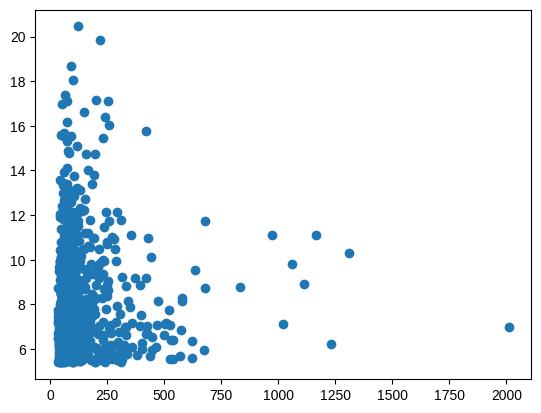

In [190]:
plt.scatter(hits.N.apply(np.mean), -np.log10(hits.scorr_p))

#### Second iteration of work

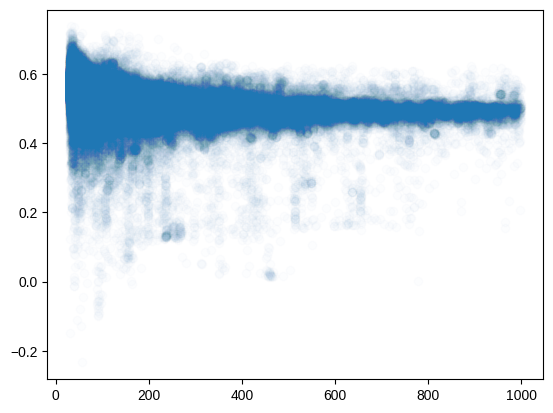

In [40]:
plt.scatter(data.N, data.nu, alpha=0.01)
    

##### Exponential model of N vs. nu

In [294]:
x = data.N
y = data.nu

# Binning x
bins=1000
bin_edges = np.linspace(np.min(x), np.max(x), bins + 1)
bin_indices = np.digitize(x, bin_edges)
bin_x = (bin_edges[1:] + bin_edges[:-1])/2

# Binning y
bin_y = np.zeros(bins)
bin_y_err = np.zeros(bins)
for i in range(bins):
    bin_mask = (bin_indices == i + 1)
    bin_y[i] = np.mean(y[bin_mask])
    bin_y_err[i] = np.std(y[bin_mask])/np.sqrt(bin_mask.sum())

In [295]:
# Fitting model
model = lambda N, a, b, c: b*np.exp(-N/a) + c
popt, pcov = curve_fit(model, x, y, (10,0.1,0.5))

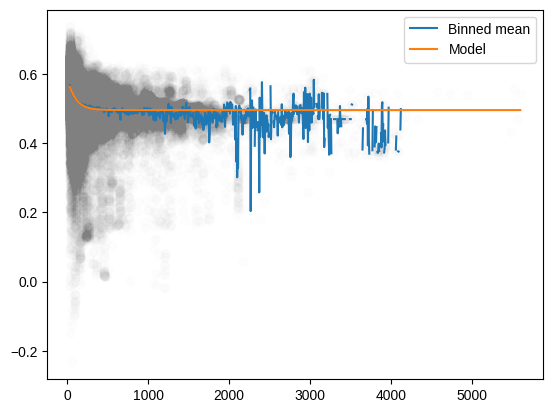

In [296]:
plt.scatter(data.N, data.nu, alpha=0.01, color='grey')
plt.plot(bin_x, bin_y, label='Binned mean')
plt.plot(bin_x, model(bin_x, *popt), label='Model')
plt.legend()

In [298]:
def global_model_p(N, nu):
    # Defining variables
    x = N
    y = nu

    # Null model
    try:
        npopt, npcov = curve_fit(nmodel, x, y, popt[2])
    except:
        return None

    # Alternative model
    amodel = model
    try:
        apopt, apcov = curve_fit(model, x, y, popt)
    except:
        return None

    # Calculate the degrees of freedom
    n = len(y) 
    nparam = len(npopt) 
    aparam = len(apopt)
    adof = n - aparam

    # Calculate the sum of squares residuals
    nrss = np.sum((y - nmodel(x, *npopt))**2)
    arss = np.sum((y - amodel(x, *apopt))**2)

    # Calculate the F-statistic and p-value
    F = ((nrss - arss) / (aparam - nparam)) / (arss / adof)
    p = 1 - f_dist.cdf(F, aparam - nparam, adof)

    return p

In [299]:
families['gmodel_p'] = families.apply(lambda row: global_model_p(row.N, row.nu), axis=1)

/storage1/fknudsen/software/miniconda3/envs/orthoidp/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_31696/226538122.py:2: RuntimeWarning: overflow encountered in exp
  model = lambda N, a, b, c: b*np.exp(-N/a) + c


In [300]:
# Confusion matrix of Pearson vs. Spearman direction and signficance
pd.crosstab(
    [families.scorr_p < p_cutoff, families.pcorr_p < p_cutoff],
    [families.gmodel_p < p_cutoff],
    rownames=['Spearman', 'Pearson'],
    colnames=['Global model'])

Global model      False  True 
Spearman Pearson              
False    False     9959    312
         True      1011    184
True     False      207     12
         True       587    138

F-test p-value: 5.40e-10
Reject null model: True


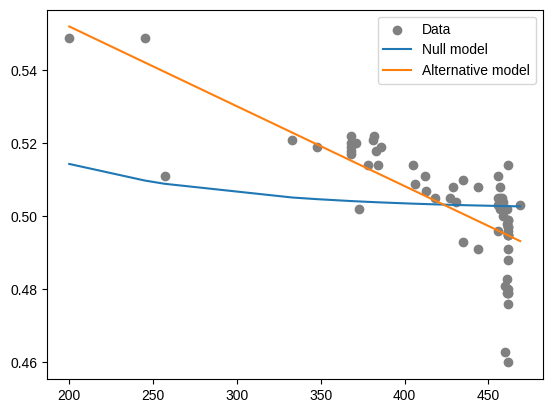

In [344]:
# Setting data
example = families[families.gmodel_p < p_cutoff].sample(1).iloc[0]
x = example.N
y = example.nu
y = y[x.argsort()]
x = x[x.argsort()]

# Null model
nmodel = lambda N, c: model(N, popt[0], popt[1], c)
npopt, npcov = curve_fit(nmodel, x, y, popt[2])

# Alternative model
amodel = model
apopt, apcov = curve_fit(model, x, y, popt)

# Plotting
plt.scatter(x, y, label='Data', color='grey')
plt.plot(x, nmodel(x, *npopt), label='Null model')
plt.plot(x, amodel(x, *apopt), label='Alternative model')

plt.legend()



# Calculate the degrees of freedom
n = len(y) 
nparam = len(npopt) 
aparam = len(apopt)
adof = n - aparam

# Calculate the sum of squares residuals
nrss = np.sum((y - nmodel(x, *npopt))**2)
arss = np.sum((y - amodel(x, *apopt))**2)

# Calculate the F-statistic and p-value
F = ((nrss - arss) / (aparam - nparam)) / (arss / adof)
p_value = 1 - f_dist.cdf(F, aparam - nparam, adof)
print(f"F-test p-value: {p_value:.2e}")
print(f"Reject null model: {p_value < p_cutoff}")

In [3]:
data

,protein,fasta,N,HUMAN,first,last,mean_lambda,faro,fR,fK,...,fD,shd,N_FL,omaid,canonicalid,scd,kappa,fcr,ncpr,nu
0,HUMAN28529_96to137,ILNQPSTQIVANAKGAVTGAKDAVTTTVTGAKDSVASTITGV,42,HUMAN28529_96to137,96,137,0.362880,0.000000,0.000000,0.071429,...,0.047619,2.376418,693.0,HUMAN28529,AGRG1_HUMAN,-0.054573,0.151679,0.119048,0.023810,0.582
1,NOMLE04692_141to182,ILNQPSTQIVASAKGAVTGAKDAVTTTVTGAKDSVASTITGV,42,HUMAN28529_96to137,141,182,0.363760,0.000000,0.000000,0.071429,...,0.047619,2.382591,206.0,NOMLE04692,G1S354,-0.054573,0.151679,0.119048,0.023810,0.582
2,PROCO08232_96to137,ILNQPSTQVVANAKGVVTGAKDAVTTTVTGAKDSVASTITGV,42,HUMAN28529_96to137,96,137,0.353358,0.000000,0.000000,0.071429,...,0.047619,2.311028,434.0,PROCO08232,A0A2K6GS49,-0.054573,0.151679,0.119048,0.023810,0.583
3,SAIBB13662_96to137,ILNQPSTQVVANAKDAVTGAKDAMTTTVTGAKDSVASTITGV,42,HUMAN28529_96to137,96,137,0.346790,0.000000,0.000000,0.071429,...,0.071429,2.264823,437.0,SAIBB13662,A0A2K6UAA3,-0.070864,0.073626,0.142857,0.000000,0.586
4,MYOLU08979_96to137,ILNQPTKQVVANAKGAVTGAKDAVTTTVTGAKDSVTSTITGV,42,HUMAN28529_96to137,96,137,0.350487,0.000000,0.000000,0.095238,...,0.047619,2.293295,451.0,MYOLU08979,G1PH01,0.002937,0.154946,0.142857,0.047619,0.583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33806,CAVAP12566_485to535,PSFLLLIQQDMTQPKRTFTTVRTPKDIASENSISRCVTNSFPLLLQ...,50,HUMAN15348_487to547,485,535,0.452931,0.060000,0.060000,0.040000,...,0.040000,3.138611,554.0,CAVAP12566,ENSCAPG00000008308.1,-0.087124,0.309776,0.160000,0.040000,0.547
33807,TAKRU02187_454to497,GATDGAQKDSTVKKVHQVTGETRSSSVVAFSPDSCLTCPTSPAV,44,HUMAN15348_487to547,454,497,0.370222,0.022727,0.022727,0.068182,...,0.068182,2.495675,261.0,TAKRU02187,H2S765,-0.220314,0.218576,0.181818,0.000000,0.570
33808,LINUN04385_463to536,AYMGSTESLDSLGGAFALNGTWYGIELDRPAGKNDGSVNGDRYFTC...,74,HUMAN15348_487to547,463,536,0.469801,0.108108,0.040541,0.054054,...,0.067568,3.661558,571.0,LINUN04385,g29387,-0.510270,0.222715,0.202703,-0.013514,0.520
33809,CAPTE31298_494to626,DMDESLEPLKMQPLEPSRRLSNGSNGSQLSPNSSFSKKTSRPWSSG...,133,HUMAN15348_487to547,494,626,0.478558,0.060150,0.082707,0.060150,...,0.022556,4.308551,634.0,CAPTE31298,N1PBE5,-0.009880,0.230914,0.233083,0.052632,0.500
